In [1]:
import numpy as np
import os, sys
import matplotlib.pyplot as plt
import slsim
from slsim.lens_pop import LensPop
from slsim.Observations.roman_speclite import configure_roman_filters
from slsim.Observations.roman_speclite import filter_names
import speclite
from astropy.cosmology import FlatLambdaCDM
from astropy.units import Quantity
from tqdm import tqdm
from hydra import initialize, compose

# set paths to various directories based on the machine this code is being executed on
with initialize(version_base=None, config_path='config'):
    config = compose(config_name='config.yaml')  # overrides=['machine=uzay']

array_dir, data_dir, figure_dir, pickle_dir, repo_dir  = config.machine.array_dir, config.machine.data_dir, config.machine.figure_dir, config.machine.pickle_dir, config.machine.repo_dir

# enable use of local modules
if repo_dir not in sys.path:
    sys.path.append(repo_dir)

# set matplotlib style
plt.style.use(f'{repo_dir}/mejiro/mplstyle/science.mplstyle')

from mejiro.utils import util

In [2]:
import mejiro
module_path = os.path.dirname(mejiro.__file__)
skypy_config = os.path.join(module_path, 'data', 'hwo.yml')
config_dict = util.load_skypy_config(skypy_config)
survey_area = float(config_dict['fsky'][:-5])

In [3]:
cosmo = FlatLambdaCDM(H0=70, Om0=0.3)
sky_area = Quantity(value=survey_area, unit='deg2')

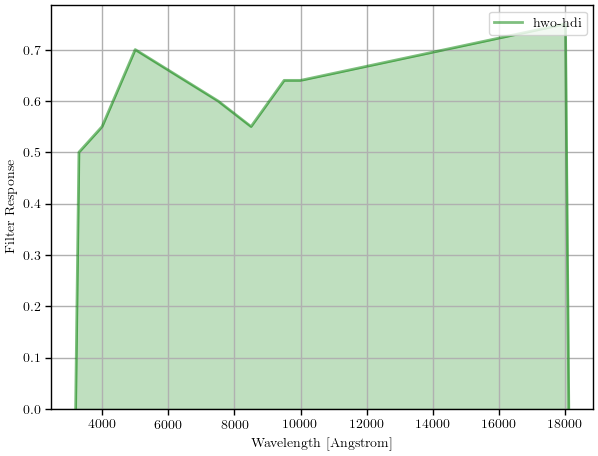

In [4]:
hwo_filter_path = os.path.join(repo_dir, 'mejiro', 'data', 'hwo-hdi.ecsv')
hdi = speclite.filters.load_filters(hwo_filter_path)

speclite.filters.plot_filters(hdi)

In [5]:
kwargs_deflector_cut = {"band": "hdi", "band_max": 28, "z_min": 0.01, "z_max": 3.0}
kwargs_source_cut = {"band": "hdi", "band_max": 29, "z_min": 0.01, "z_max": 5.0}

lens_pop = LensPop(
    deflector_type="all-galaxies",
    source_type="galaxies",
    kwargs_deflector_cut=kwargs_deflector_cut,
    kwargs_source_cut=kwargs_source_cut,
    kwargs_mass2light=None,
    skypy_config=skypy_config,
    sky_area=sky_area,
    cosmo=cosmo,
)

In [6]:
kwargs_lens_cut = {
    "min_image_separation": 0.2,
    "max_image_separation": 10,
    "mag_arc_limit": {"hdi": 27},
}

lens_population = lens_pop.draw_population(kwargs_lens_cuts=kwargs_lens_cut)

print("Number of lenses:", len(lens_population))

Number of lenses: 770


In [7]:
from lenstronomy.Data.pixel_grid import PixelGrid
from lenstronomy.Data.psf import PSF
from lenstronomy.ImSim.image_model import ImageModel
from lenstronomy.LensModel.lens_model import LensModel
from lenstronomy.LightModel.light_model import LightModel
from lenstronomy.SimulationAPI.ObservationConfig import Roman
from lenstronomy.Util import data_util, util


def get_snr(gglens, band):
    total_image, lens_surface_brightness, source_surface_brightness = get_image(gglens, band)

    # calculate region for source surface brightness array and count signal
    stdev = np.std(source_surface_brightness)
    mean = np.mean(source_surface_brightness)
    mask = source_surface_brightness < mean + (1 * stdev)
    masked_source = np.ma.masked_array(source_surface_brightness, mask=mask)
    sum_source_counts = np.sum(masked_source)

    # estimate and add background
    min_zodiacal_light_f106 = 0.29
    thermal_background_f106 = 0
    estimated_background = (min_zodiacal_light_f106 * 1.5) + thermal_background_f106  # in counts/pixel
    estimated_background *= np.ones(total_image.shape)
    total_image += estimated_background

    # estimated total noise in 180s from https://roman.gsfc.nasa.gov/science/WFI_technical.html
    noise_180s = 5.5  # e- RMS
    noise_rms = noise_180s * (146 / 180)
    noise_array = np.random.poisson(noise_rms, total_image.shape)
    total_image += noise_array

    # count total signal
    masked_total = np.ma.masked_array(total_image, mask=mask)
    sum_total_counts = np.sum(masked_total)

    # calculate estimated SNR
    return sum_source_counts / np.sqrt(sum_total_counts), total_image


def get_image(gglens, band):
    kwargs_model, kwargs_params = gglens.lenstronomy_kwargs(band=band)

    magnitude_zero_point = 30
    lens_model = LensModel(kwargs_model['lens_model_list'])
    source_light_model = LightModel(kwargs_model['source_light_model_list'])
    lens_light_model = LightModel(kwargs_model['lens_light_model_list'])
    kwargs_lens = kwargs_params['kwargs_lens']
    kwargs_source = kwargs_params['kwargs_source']
    kwargs_lens_light = kwargs_params['kwargs_lens_light']
    kwargs_source_amp = data_util.magnitude2amplitude(source_light_model, kwargs_source, magnitude_zero_point)
    kwargs_lens_light_amp = data_util.magnitude2amplitude(lens_light_model, kwargs_lens_light, magnitude_zero_point)

    # set up image
    num_pix = 610  # at 8.2 mas/pixel, 5"
    psf_class = PSF(**{'psf_type': 'GAUSSIAN', 'fwhm': 0.0021})
    kwargs_numerics = {
        'supersampling_factor': 1,
        'supersampling_convolution': False
    }
    _, _, ra_at_xy_0, dec_at_xy_0, _, _, Mpix2coord, Mcoord2pix = util.make_grid_with_coordtransform(
        numPix=num_pix,
        deltapix=0.0082,
        subgrid_res=1,
        left_lower=False,
        inverse=False)
    kwargs_pixel = {'nx': num_pix, 'ny': num_pix,  # number of pixels per axis
                    'ra_at_xy_0': ra_at_xy_0,
                    'dec_at_xy_0': dec_at_xy_0,
                    'transform_pix2angle': Mpix2coord}
    pixel_grid = PixelGrid(**kwargs_pixel)
    image_model = ImageModel(data_class=pixel_grid,
                             psf_class=psf_class,
                             lens_model_class=lens_model,
                             source_model_class=source_light_model,
                             lens_light_model_class=lens_light_model,
                             kwargs_numerics=kwargs_numerics)

    # get surface brightness arrays
    lens_surface_brightness = image_model.lens_surface_brightness(kwargs_lens_light_amp)
    source_surface_brightness = image_model.source_surface_brightness(kwargs_source_amp, kwargs_lens)
    total_image = image_model.image(kwargs_lens=kwargs_lens,
                                    kwargs_source=kwargs_source_amp,
                                    kwargs_lens_light=kwargs_lens_light_amp)

    return total_image, lens_surface_brightness, source_surface_brightness

In [8]:
detectable_gglenses, snr_list = [], []
for candidate in tqdm(lens_population):
    # 1. Einstein radius and Sersic radius
    _, kwargs_params = candidate.lenstronomy_kwargs(band='hdi')
    lens_mag = candidate.deflector_magnitude(band='hdi')

    if kwargs_params['kwargs_lens'][0]['theta_E'] < kwargs_params['kwargs_lens_light'][0][
        'R_sersic'] and lens_mag < 15:
        continue

    # 2. SNR
    snr, _ = get_snr(candidate, 'hdi')
    snr_list.append(snr)

    if snr < 10:
        continue

    # if both criteria satisfied, consider detectable
    detectable_gglenses.append(candidate)

  0%|          | 1/770 [00:00<02:12,  5.81it/s]

100%|██████████| 770/770 [02:12<00:00,  5.82it/s]


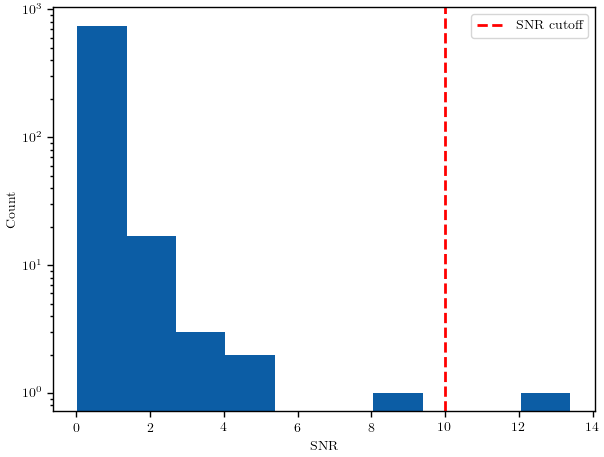

In [9]:
plt.hist(snr_list)
plt.xlabel('SNR')
plt.ylabel('Count')
plt.yscale('log')
plt.axvline(10, color='r', linestyle='--', label='SNR cutoff')
plt.legend()
plt.show()

In [10]:
print(f'Number of detectable lenses in the population: {len(detectable_gglenses)}')
print(f'Percentage detectable in population 1: {len(detectable_gglenses) / len(lens_population) * 100:.2f}%')

Number of detectable lenses in the population: 1
Percentage detectable in population 1: 0.13%
